In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
import torchvision.transforms as transforms
import torchvision.models as models

In [0]:
import copy

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

## **Load images**

In [0]:
from google.colab import files
uploaded = files.upload()

Saving edvard.jpg to edvard.jpg
Saving soso.jpg to soso.jpg


In [0]:
%ls

edvard.jpg  sample_data/  soso.jpg


In [0]:
# desired size of output image

img_size = 512 if torch.cuda.is_available() else 128

In [0]:
loader = transforms.Compose([
    transforms.Resize([img_size, img_size]), # scale imported image
    transforms.ToTensor()        # transform it into a torch tensor
])

In [0]:
def image_loader(image_name):
  image = Image.open(image_name)
  # 'unsqueeze' makes fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  
  return image.to(device, torch.float)

In [0]:
style_img = image_loader('edvard.jpg')

In [0]:
content_img = image_loader("soso.jpg")

In [0]:
content_img

tensor([[[[0.4980, 0.4980, 0.4980,  ..., 0.5686, 0.5686, 0.5686],
          [0.5020, 0.5020, 0.5059,  ..., 0.5686, 0.5686, 0.5686],
          [0.5059, 0.5059, 0.5098,  ..., 0.5686, 0.5686, 0.5686],
          ...,
          [0.4275, 0.4275, 0.4235,  ..., 0.7608, 0.6706, 0.6588],
          [0.8824, 0.8824, 0.8784,  ..., 0.7647, 0.6784, 0.6588],
          [0.9059, 0.9059, 0.9137,  ..., 0.7725, 0.6824, 0.6588]],

         [[0.5059, 0.5059, 0.5059,  ..., 0.5725, 0.5725, 0.5725],
          [0.5098, 0.5098, 0.5137,  ..., 0.5725, 0.5725, 0.5725],
          [0.5137, 0.5137, 0.5176,  ..., 0.5725, 0.5725, 0.5725],
          ...,
          [0.4353, 0.4353, 0.4314,  ..., 0.7529, 0.6118, 0.5294],
          [0.8863, 0.8824, 0.8784,  ..., 0.7569, 0.6235, 0.5373],
          [0.9059, 0.9059, 0.9137,  ..., 0.7608, 0.6275, 0.5333]],

         [[0.5020, 0.5020, 0.5020,  ..., 0.5804, 0.5804, 0.5804],
          [0.5059, 0.5059, 0.5098,  ..., 0.5804, 0.5804, 0.5804],
          [0.5098, 0.5098, 0.5137,  ..., 0

In [0]:
content_img.shape

torch.Size([1, 3, 512, 512])

In [0]:
style_img.size()

torch.Size([1, 3, 512, 512])

In [0]:
unloader = transforms.ToPILImage() # reconvert into PIL image

In [0]:
plt.ion()

def imshow(tensor, title=None):
  
  tensor = tensor.clone() # we clone the tensor to not do changes on it
  image = tensor.cpu()
  image = image.squeeze(0) # remove the fake batch dimension
  image = unloader(image)
  
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated 

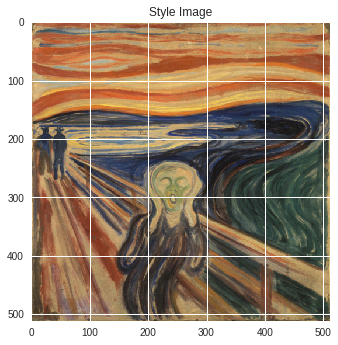

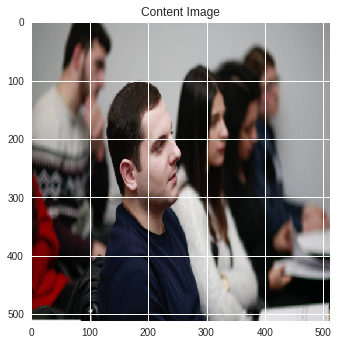

In [0]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## **Loss Functions**

In [0]:
class ContentLoss(nn.Module):
  
  def __init__(self, target):
    super().__init__()
    # we 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable. Otherwise the forward method of the criterion
    # will throw an error.
    self.target = target.detach()
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [0]:
def gram_matrix(input):
  a, b, c, d = input.size()  # a=batch size(=1); b=number of feature maps; (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
  
  G = torch.mm(features, features.t())  # compute the gram product
  
  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:16, 34436090.04it/s]


### Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
# create a module to normalize input image so we can easily put it in a nn.Sequential

class Normalization(nn.Module):
  
    def __init__(self, mean, std):
        super().__init__()
        # '.view' the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_3']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9']

In [0]:
def get_style_model_and_losses(cnn, 
                               normalization_mean, 
                               normalization_std,
                               style_img, 
                               content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  # func starts here
  
  cnn = copy.deepcopy(cnn)
  
  # normalization module
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  
  # just in order to have an iterable access to or list of content/syle losses
  content_losses = []
  style_losses = []
  
  # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
  # to put in modules that are supposed to be activated sequentially
  model = nn.Sequential(normalization)
  
  i = 0  # increment every time we see a conv layer
  for layer in cnn.children():
    
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
      
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      # The in-place version doesn't play very nicely with the ContentLoss
      # and StyleLoss we insert below. So we replace with out-of-place ones here.
      layer = nn.ReLU()
      
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
      
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
      
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    model.add_module(name, layer)
    
    if name in content_layers:
      # add content loss
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
    
    if name in style_layers:
      # add style loss
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
      
  # now we trim off the layers after the last content and style losses
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  # cut off other layers    
  model = model[:(i + 1)]
  
  return model, style_losses, content_losses

### Next, we select the input image. You can use a copy of the content image or white noise.

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

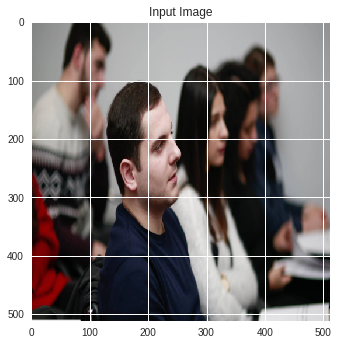

In [0]:
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=2e-1)
    return optimizer

In [0]:
def run_style_transfer(cnn, 
                       normalization_mean, 
                       normalization_std,
                       content_img, 
                       style_img, 
                       input_img, 
                       num_steps=150,
                       style_weight=1e+5, 
                       content_weight=10):
  
  # func starts here
  """Run the style transfer."""
  print('Building the style transfer model..')
  
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                   normalization_mean, 
                                                                   normalization_std, 
                                                                   style_img, 
                                                                   content_img)
  optimizer = get_input_optimizer(input_img)
  
  print('Optimizing..')
  
  run = [0]
  while run[0] <= num_steps:
    
    def closure():
      # The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. 
      # We can address this by correcting the input values to be between 0 to 1 each time the network is run.
      
      # correct the values of updated input image
      # this "clamp_" works "INPLAcE"
      input_img.data.clamp_(0, 1)
      
      optimizer.zero_grad()
      
      model(input_img)
      style_score = 0
      content_score = 0
      
      for cl in content_losses:
        content_score += cl.loss
        
      for sl in style_losses:
        style_score += sl.loss
      
      style_score *= style_weight
      content_score *= content_weight
      
      loss = style_score + content_score
      loss.backward()
      
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score, content_score))
        print()
      
      return loss
    
    
    optimizer.step(closure)
    
  # a last correction...
  input_img.data.clamp_(0, 1)
  
  return input_img

## Finally, we can run the algorithm.

In [0]:
output = run_style_transfer(cnn, 
                            cnn_normalization_mean, 
                            cnn_normalization_std,
                            content_img, 
                            style_img, 
                            input_img)

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Optimizing..
run [50]:
Style Loss : 525.628601 Content Loss: 173.071045

run [100]:
Style Loss : 77.185600 Content Loss: 100.519882

run [150]:
Style Loss : 66.727737 Content Loss: 90.486305



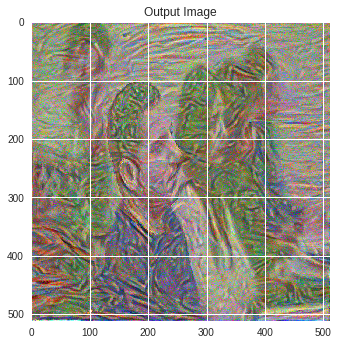

In [0]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()